# [Multivariate time series forecasting using LSTM](https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py) 

In [189]:
%reset -f
from pprint import pprint
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler 

## Functions

In [190]:
def lstmMultiSplit(df, n_past, n_future):
    """
    Split the data into training x and y sets.
    **Note: The 1st column of the df should be the label column and other columns should be features.**
    :param df: dataframe
    :param n_past: number of past days we want to use to predict the future
    :param n_future: number of days we want to look into the future based on the past days
    :return: trainX and trainX train sets
    """
    trainX = []
    trainY = []

    # n_future = 1   # Number of days we want to look into the future based on the past days.
    # n_past = 5
    
    for i in range(n_past, len(df) - n_future +1):
        trainX.append(df[i - n_past:i, 0:df.shape[1]])
        trainY.append(df[i + n_future - 1:i + n_future, 0])
    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY

## To-Do
- split date and time in feature.
- scale
- create a LSTM dataset
- train, fit , predict.

## Data pre-processing.

In [197]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True)

/home/cluster_home/yash/workspace/AutoMLRepo/Auto-ML-On-De-Pollution/autoMLVenv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [199]:
train = df[:23000]
test = df[23000:] 

In [200]:
test.shape

(736, 13)

## Train Test Split

## Scale the Training dataset 

In [201]:
scaler = StandardScaler()
scaler = scaler.fit(train)
scaledDf = scaler.transform(train)

In [203]:
scaler = scaler.fit(test)
scaledTest = scaler.transform(test)

In [184]:
# Verifying the data
pprint(df[0:1])
pprint(scaledDf[0:1])
pprint(scaler.inverse_transform(scaledDf[0]))

   wert  day  month  dayofyear  year  weekday  week  hour  temp  dwpt  rhum  \
0    36    2      1          2  2020        3     1     0   1.0  -0.6  89.0   

   prcp  
0   0.0  
array([[ 1.68034701, -1.56167389, -1.5496555 , -1.67109316, -1.15936934,
        -0.00311587, -1.65408911, -1.65843036, -1.56628065, -1.38562979,
         0.79278615, -0.15428548]])
array([ 3.60e+01,  2.00e+00,  1.00e+00,  2.00e+00,  2.02e+03,  3.00e+00,
        1.00e+00,  0.00e+00,  1.00e+00, -6.00e-01,  8.90e+01,  0.00e+00])


In [202]:
trainX, trainY = lstmMultiSplit(df=scaledDf, n_past=5, n_future=1)

In [208]:
testX, testY = lstmMultiSplit(df=scaledTest, n_past=5, n_future=1)

## Model

In [205]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()

history = model.fit(trainX, trainY, epochs=5, batch_size=14, validation_split=0.1, verbose=1)

Epoch 1/5
1479/1479 [==============================] - 14s 8ms/step - loss: 0.0369 - val_loss: 0.0036
Epoch 2/5
1479/1479 [==============================] - 12s 8ms/step - loss: 0.0197 - val_loss: 0.0254
Epoch 3/5
1479/1479 [==============================] - 13s 9ms/step - loss: 0.0190 - val_loss: 0.0056
Epoch 4/5
1479/1479 [==============================] - 13s 9ms/step - loss: 0.0190 - val_loss: 0.0456
Epoch 5/5
1479/1479 [==============================] - 12s 8ms/step - loss: 0.0188 - val_loss: 0.0262


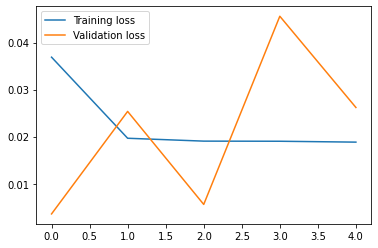

In [206]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

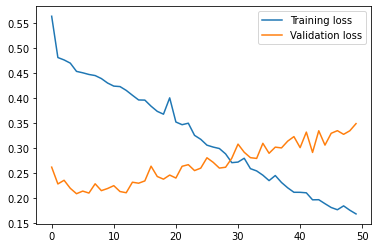

In [179]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

In [209]:
prediction = model.predict(testX)

In [ ]:
prediction = np.repeat(prediction, 13, axis=-1)

# realPrediction = scaler.inverse_transform(prediction)
# readlTestY = scaler.inverse_transform(testY)
realPrediction[:,0]

array([], shape=(0, 13), dtype=float32)

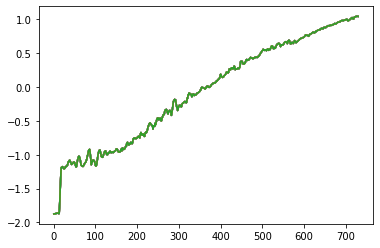

In [213]:
plt.plot(prediction, label='prediction')
# plt.plot(testY, label='y_test')
plt.show()

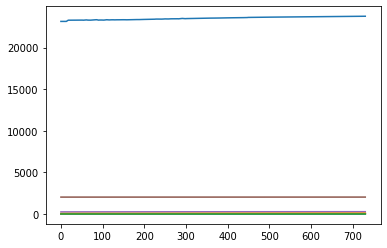

In [214]:
plt.plot(realPrediction,label='real-prediction')
# plt.plot(readlTestY,label='real-testY')
plt.led
plt.show()